This notebook generates the deprojected radius plot, MaNGA H$\alpha$ velocity map, and image cut-out of a single SGA galaxy.

In [1]:
import os
import requests

import numpy as np
import numpy.ma as ma

from astropy.table import Table
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA')
from plot_funcs import plot_radec_DESI
sys.path.insert(2, '/global/u1/k/kadglass/RotationCurves/spirals')
from DRP_rotation_curve import extract_data
from DRP_rotation_curve_plottingFunctions import plot_Ha_vel
from DRP_vel_map_functions import deproject_spaxel
from dark_matter_mass_v1 import rot_fit_BB

In [2]:
mpl.rc('font', size=12)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h

c = const.c

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Import data

## DESI PV

In [4]:
tf_targets = Table.read('../TF/cache/tf_targets_everest.fits')

## SGA

In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

## SDSS MaNGA cross-match file

In [6]:
SGA_MaNGA = Table.read('MaNGA_DESI_galaxies_08042021.txt', format='ascii.commented_header')

## MaNGA fits

In [75]:
MaNGA_fits = Table.read('DESI_vel_map_results_BB_smooth_lt_1p85_v2.txt', 
#MaNGA_fits = Table.read('DESI_vel_map_results_BB_smooth_lt_1p85_v1.txt', 
                        format='ascii.commented_header')

## Extract data for desired galaxy

In [76]:
gal_id = '8932-12701'

plate, IFU = gal_id.split('-')

SGA_MaNGA_idx = (SGA_MaNGA['MaNGA_plate'] == int(plate)) & (SGA_MaNGA['MaNGA_IFU'] == int(IFU))
MaNGA_idx = MaNGA_fits['plateifu'] == gal_id
sga_id = SGA_MaNGA['sga_id'][SGA_MaNGA_idx][0]
SGA_idx = SGA['SGA_ID'] == sga_id

PV_indices = tf_targets['SGA_ID'] == sga_id

gal_PV_obs = tf_targets[PV_indices]

SGA_info = SGA[SGA_idx]

MaNGA_fit = MaNGA_fits[MaNGA_idx]

MaNGA_fit

MaNGA_plate,MaNGA_IFU,sga_id,BA,PA,plateifu,v_sys,v_sys_err,x0,x0_err,y0,y0_err,r_turn,r_turn_err,v_max,v_max_err,chi2,alpha,alpha_err,nsa_elpetro_th90,fit_flag,smoothness_score,M90,M90_err
int64,int64,int64,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8932,12701,819754,0.684948742389679,62.18381118774414,8932-12701,62.773664854283545,13.293481075014485,47.99999984000197,3.530102558789619,29.196701149251187,2.336522481372455,5.317699077477131,0.6626295852554077,169.01498527750647,20.45121240493454,77.67217381504628,10.526404379438805,8.6520238472589,24.424760818481445,-2.0,0.5676048642113095,10.771323622512059,10.385309466919642


In [60]:
ba = SGA_MaNGA['BA'][SGA_MaNGA_idx][0]
cosi = np.sqrt((ba**2 - q0**2)/(1 - q0**2))
i_angle = np.arccos(cosi)
#i_angle = np.arccos(ba)
#print(i_angle*180/np.pi, np.arccos(ba)*180/np.pi)

phi = SGA_MaNGA['PA'][SGA_MaNGA_idx][0] + 180

r26 = 0.5*SGA_info['D26'][0]*u.arcmin
scale_r26 = MANGA_SPAXEL_SIZE/r26.to('arcsec') #spaxels to R26

# MaNGA rotation curve best-fit parameters
x0 = MaNGA_fit['x0'][0]
y0 = MaNGA_fit['y0'][0]
v_sys = MaNGA_fit['v_sys'][0]
R_turn = MaNGA_fit['r_turn'][0]
V_max = MaNGA_fit['v_max'][0]
alpha = MaNGA_fit['alpha'][0]

gal_PV_obs

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64
TFT,819754,1070748764471296,194.109731535581,27.286937803871,0,125,194.109754320792,27.286921909931,1.36278153283537,9.21418402485305e-05,GALAXY,1.01168897375464,4
TFT,819754,1070748764471297,194.112875853915,27.2883545057908,0,128,194.112835311759,27.288366767408,1.38071290020181,0.000107240480441129,GALAXY,0.988000676035881,4
TFT,819754,1070748764471298,194.115999924403,27.2898905287336,0,126,194.11600974993,27.2898553378398,0.0248462775286982,6.20629176032058e-06,GALAXY,1096.72823498584,0
TFT,819754,1070748764471299,194.122194841028,27.2927405922374,0,129,194.122172137543,27.2927447111501,0.0254188150204449,2.88110704711352e-06,GALAXY,2692.91505356133,0
TFT,819754,1070748764471300,194.125369123201,27.2942528004485,0,127,194.125346826012,27.2942330707831,1.49115723016009,7.73056796038628e-05,GALAXY,0.825128763914108,4
TFT,819754,1083942904004609,194.112838782183,27.2884012977627,0,454,194.112835311759,27.288366767408,0.0248556032442558,1.32789827908079e-05,GALAXY,95.2377723334357,0
TFT,819754,39628422527321535,194.11904551256,27.2913043473923,0,121,194.119090903652,27.2913000582538,0.02508590881376,2.90303886980132e-06,GALAXY,5944.89534626901,0


In [61]:
SGA_info

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
819754,SGA-2020 819754,IC3913,44147,194.119074,27.291296399999997,SABc,56.55,0.66374314,0.6729767,0.02503365,23.29948,15.561,False,LEDA-20181114,300775,IC3913,1,True,194.119074,27.291296399999997,0.66374314,1941p272,194.11909090365222,27.291300058253796,1.1258025,SB26,62.18381,0.68494874,194.11874732752742,27.29151684825472,27.495604,11.627079,11.487172,11.374232,8.811883,12.574175,15.883417,18.836275,21.46396,24.225271,27.262903,30.491333,33.774075,16.3868,15.823345,15.4225025,15.929263,15.382928,14.99679,15.65667,15.127425,14.754254,15.50563,14.985065,14.615441,15.429384,14.909834,14.540606,15.378387,14.857836,14.489713,15.340093,14.818501,14.449034,15.311967,14.788319,14.418165,15.292057,14.767998,14.397071,0.032725457,0.038456,0.036058344,0.034766424,0.032377526,0.051642604,0.054100893,0.110836364,0.15127675,0.011737631,0.012080677,0.011271152,0.008011917,0.008305215,0.007850536,0.0064118234,0.0067292554,0.0063456125,0.005628713,0.0059054694,0.005633241,0.005263164,0.005527273,0.0052749887,0.005049149,0.0053198077,0.005037724,0.0048803343,0.005137938,0.0048631285,0.0047600935,0.0050030868,0.0047363564,0.0046789725,0.004916977,0.0046556266,15.265369,0.3551226,13.618576,4.1141553,5.8209224,14.730954,0.3858721,10.0957365,3.716,3.2945,14.353831,0.39658108,8.922855,3.5209982,2.897923,0


### MaNGA maps

In [62]:
MANGA_FOLDER = '/project/projectdirs/sdss/data/sdss/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

Ha_vel, Ha_vel_ivar, Ha_vel_mask, _, _, Ha_flux, Ha_flux_ivar, Ha_flux_mask, _, _, _ = extract_data(VEL_MAP_FOLDER, gal_id)

### Hessian (from best-fit to MaNGA data)

In [63]:
Hessian = np.load('DRP_map_Hessians/' + gal_id + '_Hessian.npy')

hess_inv = 2*np.linalg.inv(Hessian)

# Calculate DESI data points

## Calculate the distance between the SGA galaxy center and each observation

In [64]:
SGA_coords = SkyCoord(ra=SGA_info['RA'], dec=SGA_info['DEC'], unit=u.degree)
target_coords = SkyCoord(ra=gal_PV_obs['FIBER_RA'], dec=gal_PV_obs['FIBER_DEC'], unit=u.degree)

sep2d = target_coords.separation(SGA_coords)

gal_PV_obs['SKY_FIBER_DIST'] = sep2d
gal_PV_obs['SKY_FIBER_DIST_R26'] = sep2d.to('arcmin')/r26

gal_PV_obs

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
,,,,,,,,,,,,,,deg,
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,float64,float64
TFT,819754,1070748764471296,194.109731535581,27.286937803871,0,125,194.109754320792,27.286921909931,1.36278153283537,9.21418402485305e-05,GALAXY,1.01168897375464,4,0.009392208293257162,1.001121402941111
TFT,819754,1070748764471297,194.112875853915,27.2883545057908,0,128,194.112835311759,27.288366767408,1.38071290020181,0.000107240480441129,GALAXY,0.988000676035881,4,0.006259647909301766,0.6672198168109763
TFT,819754,1070748764471298,194.115999924403,27.2898905287336,0,126,194.11600974993,27.2898553378398,0.0248462775286982,6.20629176032058e-06,GALAXY,1096.72823498584,0,0.0030874582416960143,0.3290941203537658
TFT,819754,1070748764471299,194.122194841028,27.2927405922374,0,129,194.122172137543,27.2927447111501,0.0254188150204449,2.88110704711352e-06,GALAXY,2692.91505356133,0,0.003111907221660042,0.3317001525410671
TFT,819754,1070748764471300,194.125369123201,27.2942528004485,0,127,194.125346826012,27.2942330707831,1.49115723016009,7.73056796038628e-05,GALAXY,0.825128763914108,4,0.006312467208002649,0.6728498591574346
TFT,819754,1083942904004609,194.112838782183,27.2884012977627,0,454,194.112835311759,27.288366767408,0.0248556032442558,1.32789827908079e-05,GALAXY,95.2377723334357,0,0.006266955775128379,0.6679987668364029
TFT,819754,39628422527321535,194.11904551256,27.2913043473923,0,121,194.119090903652,27.2913000582538,0.02508590881376,2.90303886980132e-06,GALAXY,5944.89534626901,0,4.056585511771998e-05,0.004323940070208334


## Calculate the rotational velocities

If there is more than one observation of the galactic center, use the average redshift for the center redshift.

In [65]:
# Remove observations that RedRock fit as a STAR
stars = gal_PV_obs['SPECTYPE'] == 'STAR'
gal_PV_obs_gal = gal_PV_obs[~stars]

is_sga_center = (gal_PV_obs_gal['TARGETID'] > 30000000000000000) & (gal_PV_obs_gal['TARGETID'] < 40000000000000000)

z_center = np.mean(gal_PV_obs_gal['Z'][is_sga_center])
z_center_err = np.sqrt(np.sum((gal_PV_obs_gal['Z'][is_sga_center]/np.sum(is_sga_center))**2 * gal_PV_obs_gal['ZERR'][is_sga_center]**2))

dz = np.abs(gal_PV_obs_gal['Z'] - z_center)
dz_err = np.sqrt(gal_PV_obs_gal['ZERR']**2 + z_center_err**2)

gal_PV_obs_gal['V'] = dz*c.to('km/s')
gal_PV_obs_gal['VERR'] = dz_err*c.to('km/s')

# Remove observations that do not have good redshifts (Vrot > 1000 km/s)
good_v = gal_PV_obs_gal['V'] < 1000
gal_PV_obs_good = gal_PV_obs_gal[good_v]

gal_PV_obs_good

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,V,VERR
,,,,,,,,,,,,,,deg,,km / s,km / s
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,float64,float64,float64,float64
TFT,819754,1070748764471298,194.115999924403,27.2898905287336,0,126,194.11600974993,27.2898553378398,0.0248462775286982,6.20629176032058e-06,GALAXY,1096.72823498584,0,0.0030874582416960143,0.3290941203537658,71.83965196237604,1.8607275500409335
TFT,819754,1070748764471299,194.122194841028,27.2927405922374,0,129,194.122172137543,27.2927447111501,0.0254188150204449,2.88110704711352e-06,GALAXY,2692.91505356133,0,0.003111907221660042,0.3317001525410671,99.80276998552196,0.8640100479395625
TFT,819754,1083942904004609,194.112838782183,27.2884012977627,0,454,194.112835311759,27.288366767408,0.0248556032442558,1.32789827908079e-05,GALAXY,95.2377723334357,0,0.006266955775128379,0.6679987668364029,69.04387277275421,3.9809987576674195
TFT,819754,39628422527321535,194.11904551256,27.2913043473923,0,121,194.119090903652,27.2913000582538,0.02508590881376,2.90303886980132e-06,GALAXY,5944.89534626901,0,4.056585511771998e-05,0.004323940070208334,0.0,0.8705829593824111


## Calculate distance to galaxy

In [66]:
distance = z_center*c.to('km/s')/(H0*u.km/u.s/u.Mpc)
#distance = 0.0256367*c.to('km/s')/(H0*u.km/u.s/u.Mpc) # redshift from NSA
#distance_kpc = distance_Mpc*1000
scale = distance.to('kpc')*np.tan(r26.to('radian')) #R26 to kpc
#scale = distance.to('kpc')*np.tan(MANGA_SPAXEL_SIZE.to('radian'))
scale_kpc = scale.value

# Deproject MaNGA spaxels

## Mask velocity map

In [67]:
SN = Ha_flux*np.sqrt(Ha_flux_ivar)

map_mask = Ha_vel_mask + Ha_flux_mask + (SN < 5)

mHa_vel = ma.array(Ha_vel, mask=map_mask)
mHa_vel_ivar = ma.array(Ha_vel_ivar, mask=map_mask)

## Deproject spaxels

In [68]:
vel_array_shape = mHa_vel.shape

r_deproj = np.zeros(vel_array_shape)
v_deproj = np.zeros(vel_array_shape)

theta = np.zeros(vel_array_shape)

for i in range(vel_array_shape[0]):
    for j in range(vel_array_shape[1]):
        
        r_deproj[i,j], theta[i,j] = deproject_spaxel((i,j), 
                                                     (x0, y0), 
                                                     phi*np.pi/180, 
                                                     i_angle)

# Scale radii to convert from spaxels to R26
r_deproj *= scale_r26.value
#r_deproj *= (distance.to('kpc')*np.tan(MANGA_SPAXEL_SIZE.to('radian'))).value

# Deproject velocity values
v_deproj = (mHa_vel - v_sys)/np.abs(np.cos(theta))
v_deproj /= np.sqrt(1 - cosi**2)
#v_deproj /= np.sin(i_angle)

# Apply masks to arrays
rm_deproj = ma.array(r_deproj, mask=mHa_vel.mask)
vm_deproj = ma.array(v_deproj, mask=mHa_vel.mask)

# Plot data

## H$\alpha$ velocity map

In [69]:
plot_Ha_vel(mHa_vel, 
            gal_id, 
            IMAGE_DIR='../Figures/', 
            FOLDER_NAME='',
            FILENAME_SUFFIX='_Ha_map.')

## MaNGA rotation curve

In [70]:
################################################################################
# Calculate best-fit rotation curve
#-------------------------------------------------------------------------------
r = np.linspace(0, 1, 100) # units of R26
#r_kpc = np.linspace(0,10,100) # units of kpc
#r = r_kpc/scale_kpc

Velocity_curve = rot_fit_BB(r*scale_kpc, [V_max, R_turn, alpha])
#Velocity_curve = rot_fit_BB(r_kpc, [V_max, R_turn, alpha])
################################################################################


################################################################################
# Calculate uncertainty in best-fit rotation curve
#-------------------------------------------------------------------------------
N_samples = 10000

random_sample = np.random.multivariate_normal(mean=[V_max, R_turn, alpha], 
                                              cov=hess_inv[-3:,-3:], 
                                              size=N_samples)

# Remove bad samples (those with negative values for any of the parameters)
is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
good_randoms = random_sample[is_good_random, :]

for i in range(len(r)):
    # Calculate values of curve at this location
    y_sample = rot_fit_BB(r[i]*scale_kpc, 
                          [good_randoms[:,0], 
                           good_randoms[:,1], 
                           good_randoms[:,2]])
    
stdevs = np.std(y_sample, axis=0)
################################################################################

/global/u1/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


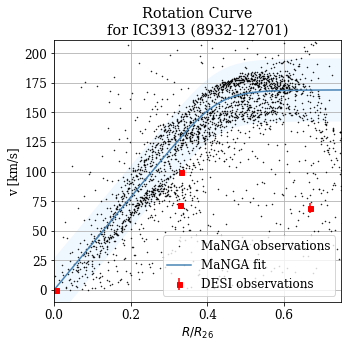

In [71]:
fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)

ax.fill_between(r, 
                Velocity_curve-stdevs, 
                Velocity_curve+stdevs, 
                facecolor='aliceblue')

ax.plot(rm_deproj, np.abs(vm_deproj), 'k.', markersize=1, label='MaNGA observations')

ax.plot(r, Velocity_curve, c='steelblue', label='MaNGA fit')

ax.errorbar(gal_PV_obs_good['SKY_FIBER_DIST_R26'], 
            gal_PV_obs_good['V'], 
            yerr=gal_PV_obs_good['VERR'], 
            fmt='rs', 
            markersize=5, 
            label='DESI observations')

plot_title = 'Rotation Curve\nfor {gname}'.format(gname = str(SGA_info['GALAXY'][0])) + ' (' + gal_id + ')'

ax.set(xlabel='$R/R_{26}$', 
       ylabel='v [km/s]', 
       xlim=(0,0.75), 
       ylim=(-10, 1.25*V_max), 
       title=plot_title)

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), fontsize=12)

ax.grid(b=True)

plt.savefig('../Figures/9863-9102_rot_curve.eps', format='eps', dpi=300);

## Legacy Survey image cutout

In [72]:
def get_cutout(sga_id, ra, dec, size, verbose=False):
    '''
    Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    sga_id : int
        SGA_ID
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    '''
    # Either load an existing image or download a cutout.
    img_name = 'cache/{}.jpg'.format(sga_id)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/819754.jpg exists.


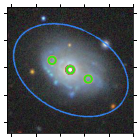

In [73]:
# Padd the image cutout of the galaxy
npix = np.minimum(int(1.025 * 2*r26.value*60/0.262), 512)

# Download image file
img_file, wcs = get_cutout(sga_id, SGA_info['RA'][0], SGA_info['DEC'][0], size=npix, verbose=True)
img = mpl.image.imread(img_file)

fig = plt.figure(figsize=(3.5,2.5))

ax = fig.add_subplot(111, projection=wcs)
ax.imshow(np.flip(img, axis=0))
#ax.set(xlabel='ra', ylabel='dec')
'''
ax.text(int(0.02*npix), 
        int(0.85*npix), 
        'SGA: {}\nMaNGA: {}\n$z={{{:.4f}}}$'.format(sga_id, gal_id, z_center), 
        fontsize=12, 
        color='yellow')
''';
#overlay = ax.get_coords_overlay('icrs')
#overlay.grid(color='white', ls='dotted');

# Add the location of the SDSS and DESI fibers.
# SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
r1_c = SphericalCircle((SGA_info['RA'][0] * u.deg, SGA_info['DEC'][0] * u.deg), 2 * u.arcsec,
                     edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                     transform=ax.get_transform('icrs'))
r2_c = SphericalCircle((SGA_info['RA'][0] * u.deg, SGA_info['DEC'][0] * u.deg), 2 * u.arcsec,
                     edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                     transform=ax.get_transform('icrs'))
ax.add_patch(r1_c)
ax.add_patch(r2_c)

for tft in gal_PV_obs_good:
    if tft['SKY_FIBER_DIST_R26'] < 0.4:
        ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])

        # Add the location of the SDSS and DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                             edgecolor='lime', facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)

fig.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)

ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

#fig.savefig('../Figures/{}_cutout.eps'.format(gal_id), format='eps', dpi=120)
fig.savefig('../Figures/{}_cutout.png'.format(gal_id), dpi=120)

## Combine all figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


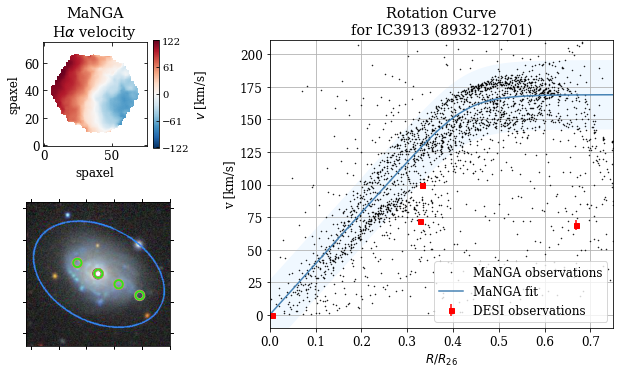

In [74]:
fig = plt.figure(figsize=(9,5))

####################################################################################
# MaNGA H-alpha velocity map
#-----------------------------------------------------------------------------------
ax1 = fig.add_axes([0.1, 0.6, 0.2, 0.3])

#plot_Ha_vel(mHa_vel, gal_id, ax=ax1)

minimum = ma.min(mHa_vel)
maximum = ma.max(mHa_vel)
if minimum > 0:
    vmax_bound = maximum
    vmin_bound = 0
else:
    vmax_bound = ma.max([np.abs(minimum), np.abs(maximum)])
    vmin_bound = -vmax_bound
cbar_ticks = np.linspace(vmin_bound, vmax_bound, 5, dtype='int')

ax1.set_title('MaNGA\n' + r'H$\alpha$ velocity')
Ha_vel_im = ax1.imshow(mHa_vel, 
                       cmap='RdBu_r', 
                       origin='lower', 
                       vmin=vmin_bound, 
                       vmax=vmax_bound)

cbar = plt.colorbar(Ha_vel_im, ax=ax1, ticks=cbar_ticks)
cbar.ax.tick_params(direction='in', labelsize=10)
cbar.set_label('$v$ [km/s]')

ax1.tick_params(axis='both', direction='in')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.set_xlabel('spaxel')
ax1.set_ylabel('spaxel')
####################################################################################


####################################################################################
# Legacy survey cutout
#-----------------------------------------------------------------------------------
ax2 = fig.add_axes([0.01, 0.05, 0.35, 0.4], projection=wcs)

ax2.imshow(np.flip(img, axis=0))

r1_c = SphericalCircle((SGA_info['RA'][0]*u.deg, SGA_info['DEC'][0]*u.deg), 
                       2*u.arcsec,
                       edgecolor='black', 
                       facecolor='none', 
                       alpha=0.8, 
                       lw=3,
                       transform=ax2.get_transform('icrs'))
r2_c = SphericalCircle((SGA_info['RA'][0]*u.deg, SGA_info['DEC'][0]*u.deg), 
                       2*u.arcsec,
                       edgecolor='red', 
                       facecolor='none', 
                       alpha=0.8, 
                       lw=2,
                       transform=ax2.get_transform('icrs'))
ax2.add_patch(r1_c)
ax2.add_patch(r2_c)

for tft in gal_PV_obs_good:
#    if tft['SKY_FIBER_DIST_R26'] < 0.4:
    ra, dec = float(tft['FIBER_RA']), float(tft['FIBER_DEC'])

    # Add the location of the SDSS and DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra*u.deg, dec*u.deg), 
                         2*u.arcsec,
                         edgecolor='lightcoral', 
                         facecolor='none', 
                         alpha=1, 
                         lw=3,
                         transform=ax2.get_transform('icrs'))
    r2 = SphericalCircle((ra*u.deg, dec*u.deg), 
                         2*u.arcsec,
                         edgecolor='lime', 
                         facecolor='none', 
                         alpha=0.8, 
                         lw=2,
                         transform=ax2.get_transform('icrs'))
    ax2.add_patch(r1)
    ax2.add_patch(r2)

ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
####################################################################################


####################################################################################
# Rotation curve
#-----------------------------------------------------------------------------------
ax3 = fig.add_axes([0.45, 0.1, 0.53, 0.8])

ax3.fill_between(r, 
                 Velocity_curve-stdevs, 
                 Velocity_curve+stdevs, 
                 facecolor='aliceblue')

ax3.plot(rm_deproj, np.abs(vm_deproj), 'k.', markersize=1, label='MaNGA observations')

ax3.plot(r, Velocity_curve, c='steelblue', label='MaNGA fit')

ax3.errorbar(gal_PV_obs_good['SKY_FIBER_DIST_R26'], 
             gal_PV_obs_good['V'], 
             yerr=gal_PV_obs_good['VERR'], 
             fmt='rs', 
             markersize=5, 
             label='DESI observations')

plot_title = 'Rotation Curve\nfor {gname}'.format(gname = str(SGA_info['GALAXY'][0])) + ' (' + gal_id + ')'

ax3.set(xlabel='$R/R_{26}$', 
        ylabel='v [km/s]', 
        xlim=(0,0.75), 
        ylim=(-10, 1.25*V_max), 
        title=plot_title)

handles, labels = ax3.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax3.legend(*zip(*unique), fontsize=12)

ax3.grid(b=True)
####################################################################################

#plt.savefig('../Figures/{}_multi.png'.format(gal_id), dpi=120)
plt.savefig('../Figures/{}_multi.eps'.format(gal_id), format='eps', dpi=120)